# Multiple Linear Regression

In reality, we have more than one predictor variable:

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data/Advertising.csv")
print(df.head())

   Unnamed: 0     TV  radio  newspaper  sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9


In the above, our predictors are TV advertising, radio advertising, and newspaper advertising. An extension of the linear model is:

$$Y = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \cdots + \beta_{p}X_{p} + \epsilon$$

where we interpret $\beta_{j}$ as the *average* effect on $Y$ of a one unit increase in $X_{j}$, **holding all other predictors fixed**.

For our dataset above, we can write:

$$sales = \beta_{0} + \beta_{1} \times TV + \beta_{2}\times radio + \beta_{p}\times newspaper + \epsilon$$

## Equations and python functions
We have already seen the matrix manipulations necessary to find the RSS (residual sum of squares) for multiple regression when looking at simple linear regression and all the functions we looked at there are relevant here. The key equations and programs are reproduced here for reference and use in what follows:

$$h_{\theta}(x) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2}$$
and associated cost function
$$J(\theta) = \frac{1}{2}\sum_{i=1}^{n}(h_{\theta}(x^{(i)}) - y^{(i)})^{2}$$

and in matrix form:
$$h(x^{(1)}) = \begin{pmatrix} \theta_{0} \theta_{1} \theta_{2} \end{pmatrix} \begin{pmatrix} x_{0}^{(1)} \\ x_{1}^{(1)} \\ x_{1}^{(1)} \end{pmatrix} = \theta^{T} \vec{x^{(1)}}$$
or
$$h(x) = X^{T}\theta$$
and for the cost function
$$\frac{1}{2}(x\theta - \vec{y})^{T}(x\theta - \vec{y}) = \frac{1}{2}\sum_{i=1}^{n}(h_{\theta}(x^{(i)}) - y^{(i)})^2 = J(\theta)$$

The gradient of the cost function can then be calculated:
$$\vec\nabla_{\theta}J(\theta) =  X^{T}X\theta - X^{T}\vec{y} $$
which gives the normal equations
$$\theta = (X^{T}X)^{-1}X^{T}\vec{y}$$
See the linear regression chapter for a detailed derivation.

In [6]:
# Define the linear regression function based on the normal equations
def linear_regression(X, y):
    # Step 2.1: Prepare the design matrix
    # X should have an intercept (column of ones) to add the bias term / intercept term
    X_design = np.c_[np.ones((X.shape[0], 1)), X]

    # Step 2.2: Calculate X^T * X
    X_transpose = X_design.T
    X_transpose_X = X_transpose.dot(X_design)

    # Step 2.3: Calculate (X^T * X)^-1
    X_transpose_X_inv = np.linalg.inv(X_transpose_X)

    # Step 2.4: Calculate X^T y
    X_transpose_y = X_transpose.dot(y)

    # Step 2.5: Calculate the coefficients theta
    theta = X_transpose_X_inv.dot(X_transpose_y)
    return theta

# Write the function for RSS and RSE
def RSS_RSE_Calc(X, y, coefs):

    # Calculate predicted values (y_hat)
    X = np.array(X) # ensure numpy array
    y = np.array(y) # ensure numpy array
    y_hat = np.dot(X, coefs[1:]) + coefs[0]

    # Calculate residuals and RSS
    residuals = y - y_hat
    RSS = np.sum(residuals ** 2)

    # Calculate RSE
    numDataPoints = len(y)
    numCoefficients = len(coefs)
    RSE = np.sqrt(RSS / (numDataPoints - numCoefficients))

    return RSS, RSE

def standard_errors(X, RSE):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    X_with_intercept_df = pd.DataFrame(X_with_intercept, columns=['Intercept'] + list(X.columns))

    # Calculate (X^T * X)^(-1)
    XtX_inv = np.linalg.inv(np.dot(X_with_intercept_df.T, X_with_intercept_df))

    # Standard error calculation
    SE_beta = np.sqrt(np.diagonal(RSE**2 * XtX_inv))

    return SE_beta

from scipy.stats import t
def calculate_t_stats_and_p_values(coefs, SE_betas, X):
    # Degrees of freedom = number of observation - number of parameters
    df = len(X) - len(coefs)
    # Calculate t-stats for each coefficient
    t_stats = np.array([coef / SE_beta for coef, SE_beta in zip(coefs, SE_betas)])

    # Calculate p-values for each coefficient
    p_values = np.array([2 * (1 - t.cdf(abs(t_stat), df)) for t_stat in t_stats])

    return t_stats, p_values

def create_summary_table(coefs, standard_errors, t_stats, p_values, feature_names):
    

    # Combine all variable names, starting with 'Intercept'
    all_variable_names = ['Intercept'] + feature_names

    # Create the summary table
    summary_table = pd.DataFrame({
        'Coefficient': coefs,
        'Std. Error': standard_errors,
        't-statistic': t_stats,
        'p_value': p_values
    }, index=all_variable_names)

    return summary_table

The above are all the functions we need to run the multiple linear regression, so let's try it.

In [8]:
features = ['TV', 'radio', 'newspaper']
X = df[features].values
y = df['sales'].values

coefs = linear_regression(X, y)
RSS, RSE = RSS_RSE_Calc(X, y, coefs)
SE_coefs = standard_errors(X, RSE)
t_stats, p_values = calculate_t_stats_and_p_values(coefs, SE_coefs, X)
create_summary_table(coefs, SE_coefs, t_stats, p_values, features)

,Coefficient,Std. Error,t-statistic,p_value
Intercept,2.938889,0.311908,9.422288,0.000000
TV,0.045765,0.001395,32.808624,0.000000
radio,0.188530,0.008611,21.893496,0.000000
newspaper,-0.001037,0.005871,-0.176715,0.859915


**Explanation of the results**

- For a given amount of TV and newspaper advertising, spending an additional $1000 on radio advertising is associated with around 189 units of additional sales.
- The coefficient estimate for newspaper advertising is very close to zero and the p-value is not significant.
- We can plot a correlation matrix (below) and we see that radio and newspaper are strongly correlated (0.35), implying that companies that spend on radio tend to simultaneously spend on radio. This means that newspaper is a surrogate for radio (i.e., running a simple linear regression with only newspaper and sales, we would expect to see a significant relation because it is collinear with radio).

                 TV     radio  newspaper     sales
TV         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000


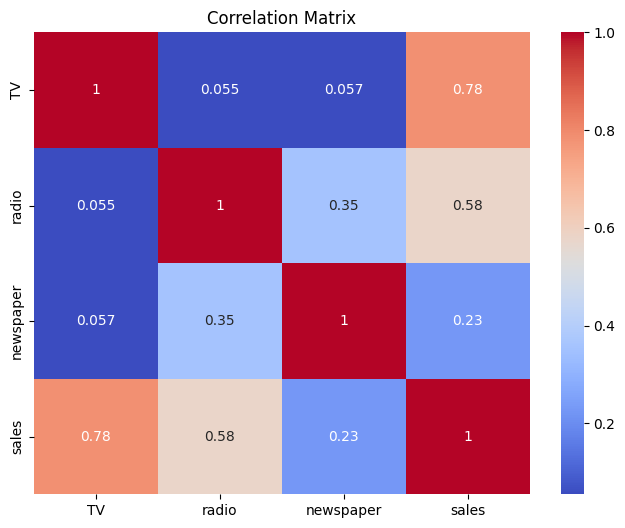

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df[['TV', 'radio', 'newspaper', 'sales']].corr()
print(corr_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()